# **RL4AA'25 Challenge Part 2:** Option RL

In this notebook you can solve the RL challenge by training your own RL agent. If you are a beginner in RL, we recommend you stick the with provided code using the PPO implementation from _Stable Baselines3_, and try to tune the hyperparameters of both the environment and the PPO algorithm through the `config` dictionary. If you are more experienced, feel free to change the algorithm or move to a completely different RL library altogether, provided you believe that it will help you solve the challenge.

## IMPORTANT: PLEASE READ BEFORE RUNNING THE NOTEBOOK

Training a good RL agent can take a lot of time. The task in this challenge was designed such that 500,000 steps should be enough to solve it well. (Though you can train longer if you think you can do better. 😉) On a Mac with an Apple-made SoC, such a training should be doable in about 10 minutes. It may take longer on other machines, expect at least 30 minutes on a recent Windows or Linux laptop.

**More importantly** this training can use a considerable amount of RAM. In the worst case, this can also cause other applications to crash when you start training. So please make sure you have nothing unsaved open on your computer before you start training, and that you follow the instructions on setting `n_envs` correctly. When in doubt use a lower number.

The following code also uses (_Weight & Biases_)[https://wandb.ai] to log the training. We recommend you create a free account there and check out the results to better understand what is happening during training. If you don't want to use _Weight & Biases_, run `wandb disabled` in a terminal in the root of this repository. You can then still use Tensorboard to visualise the training progress by running `tensorboard --logdir log/` in a terminal in the root of this repository.


In [1]:
from functools import partial
from pathlib import Path

import numpy as np
import torch.nn as nn
from rl_zoo3 import linear_schedule
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from wandb.integration.sb3 import WandbCallback

import wandb
from src.eval import Study
from src.eval.eval_rl_v3_sim import evaluate_policy
from src.train.ea_ppo import make_env
from src.utils import load_config, save_config

## Configure the RL training with the PPO algorithm from _Stable Baselines3_

Below you find the `config` dictionary that contains all the hyperparameters for the PPO algorithm and the environment. You can change the values to optimise the training of your agent.

You may also modify the `_get_reward` method of the environment to change the reward function. It can be found in [`src/environments/ea.py` line 338](src/environments/ea.py:338).


In [2]:
config = {
    # ===== Environment parameters =====
    # You may change any of these. However, be aware that in the evaluation, some of
    # these parameters are set to different values, regardless of what you set in
    # the training. It may or may not make sense to change them here. You will just have
    # to find out what happens yourself.
    # ---------------------
    # Choose weather actions set magnet settings directly (`"direct"`) or change magnet
    # settings (`"delta"`)
    "action_mode": "delta",
    # Maximum allowed quadrupole setting. The real quadrupoles can be set from -72 to
    # 72. These limits are imposed by the power supplies, but are unreasonably high to
    # the task at hand. It might therefore make sense to choose a lower value.
    "max_quad_setting": 30.0,
    # Limit of by how much quadrupole settings may be changed when `action_mode` is set
    # to `"delta"`. This parameter is ignored when `action_mode` is set to `"direct"`.
    "max_quad_delta": 30.0,
    # Limit of by how much steerer settings may be changed when `action_mode` is set to
    # `"delta"`. This parameter is ignored when `action_mode` is set to `"direct"`.
    "max_steerer_delta": 6.1782e-3,
    # Magnet initialisation on `reset`. Set to `None` for magnets to stay at their
    # current settings, `"random"` to be set to random settings or an array of five
    # values to set them to a constant value.
    "magnet_init_mode": np.array([10.0, -10.0, 0.0, 10.0, 0.0]),
    # Setting for incoming beam parameters on reset. Can be `"random"` to generate
    # random parameters or an array of 11 values to set them to a constant value.
    "incoming_mode": "random",
    # Setting for misalignment of magnets and the diagnostic screen on reset. Can be
    # `"random"` to generate random misalignments or an array of 8 values to set them to
    # a constant value.
    # NOTE: This is fixed to `"random"` in the evaluation.
    "misalignment_mode": "random",
    # Maximum misalignment of magnets and the diagnostic screen in meters when
    # `misalignment_mode` is set to `"random"`. This parameter is ignored when
    # `misalignment_mode` is set to a constant value.
    # NOTE: This is fixed to `5e-4` in the evaluation.
    "max_misalignment": 5e-4,
    # If `True`, the screen is assumed to be finite and false false beam parameters are
    # returned when the beam is not on the screen. The false beam parameters are
    # estimates of what would be measured on the real screen as a result of the camera
    # vignetting when no beam is visible.
    # NOTE: That these false beam parameters would always be returned and therefore also
    # be used for the reward computation.
    # NOTE: This is fixed to `True` in the evaluation.`
    "simulate_finite_screen": False,
    # Setting of target beam on `reset`. Set to "random" to generate a random target
    # beam or to an array of four values to set it to a constant value.
    # NOTE: This is fixed to `"np.zeros(4)"` in the evaluation. You can try training on
    # random, but this is significantly harder and out of scope for this challenge.
    "target_beam_mode": np.zeros(4),
    # If `True`, magnet settings are clipped to their allowed ranges after each step.
    "clip_magnets": True,
    # ===== Wrapper parameters =====
    # Number of observations into the past that are passed to the policy. A value of 1
    # means that only the current observation is passed.
    "frame_stack": 1,
    # Whether to scale the observations from their physical ranges to a range of [-1, 1]
    # before passing them to the policy.
    "normalize_observation": True,
    # Whether to expect the policy to output actions in the range of [-1, 1] (`True`) or
    # in the physical range of the actions (`False`).
    "rescale_action": True,
    # NOTE: Please do not change the `target_threshold` parameter.
    "target_threshold": None,
    # Number of steps per episode allowed during training before the environment is
    # reset.
    # NOTE: In the evaluation policies will be run for an arbitrary number of steps.
    "max_episode_steps": 50,
    # ===== RL algorithm parameters =====
    # Please refer to the Stable Baselines3 documentation for the meaning of these
    # parameters:
    #   https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#parameters
    # NOTE: Good settings of `n_steps` and `n_envs` depend a lot on your hardware, and
    # they depend on each other. We recommend using one of the following options based
    # on your hardware:
    #   - 32 GB RAM or more: `n_envs=40`, `n_steps=64`
    #   - 16 GB RAM: `n_envs=20`, `n_steps=128`
    #   - 8 GB RAM: `n_envs=10`, `n_steps=256`
    # USING TOO LARGE VALUES MAY CAUSE OTHER APPLICATIONS TO CRASH WITHOUT WARNING!!!
    "batch_size": 64,
    "learning_rate": 0.0003,
    "lr_schedule": "constant",  # Can be "constant" or "linear"
    "gamma": 0.99,
    "n_envs": 40,
    "n_steps": 64,
    "ent_coef": 0.0,
    "n_epochs": 10,
    "gae_lambda": 0.95,
    "clip_range": 0.2,
    "clip_range_vf": None,  # None,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "use_sde": False,
    "sde_sample_freq": -1,
    "target_kl": None,
    "total_timesteps": 500_000,
    # ===== Policy parameters =====
    # Size of the policy network. Can be "small" or "medium". Alternatively define
    # custom layer sizes below.
    "net_arch": "small",
    # Activation function of the policy network. Can be "Tanh", "ReLU" or "GELU".
    "activation_fn": "Tanh",
    # Whether or not to use orthogonal initialisation of the policy network weights.
    "ortho_init": True,  # True, False
    # Initial value of the log standard deviation of the policy network output.
    "log_std_init": 0.0,
    # ===== SB3 configuration =====
    # PyTorch device used for training. You should probably leave this at "auto".
    "sb3_device": "auto",
    # Setting for how parallel environments for training rollouts handled. Set to
    # "dummy" for parallel environments to be called in a for loop on a single process,
    # or to "subproc" for parallel environments running in separate processes.
    "vec_env": "subproc",
}

## Train your RL agent

Below is the code for training the RL agent with the PPO algorithm as implemented in _Stable Baselines3_. You probably shouldn't change this cell unless you know what you are doing. If you want to use a different algorithm, you will need to change the code below.


In [3]:
# Setup wandb
wandb.init(
    project="rl4aa-tutorial-2025",
    sync_tensorboard=True,
    monitor_gym=True,
    config=config,
    dir=".wandb",
)
config = dict(wandb.config)
config["run_name"] = wandb.run.name

# Setup vecorised environments for training and evaluation
assert config["vec_env"] in ["dummy", "subproc"]
vec_env = (
    DummyVecEnv([partial(make_env, config) for _ in range(config["n_envs"])])
    if config["vec_env"] == "dummy"
    else SubprocVecEnv([partial(make_env, config) for _ in range(config["n_envs"])])
)
eval_vec_env = DummyVecEnv(
    [partial(make_env, config, plot_episode=True, log_task_statistics=True)]
)

# Setup learning rate schedule if needed
if config["lr_schedule"] == "linear":
    config["learning_rate"] = linear_schedule(config["learning_rate"])

# Setup RL training algorithm
model = PPO(
    "MlpPolicy",
    vec_env,
    learning_rate=config["learning_rate"],
    n_steps=config["n_steps"],
    batch_size=config["batch_size"],
    n_epochs=config["n_epochs"],
    gamma=config["gamma"],
    gae_lambda=config["gae_lambda"],
    clip_range=config["clip_range"],
    clip_range_vf=config["clip_range_vf"],
    ent_coef=config["ent_coef"],
    vf_coef=config["vf_coef"],
    max_grad_norm=config["max_grad_norm"],
    use_sde=config["use_sde"],
    sde_sample_freq=config["sde_sample_freq"],
    target_kl=config["target_kl"],
    policy_kwargs={
        "activation_fn": getattr(nn, config["activation_fn"]),
        "net_arch": {  # From rl_zoo3
            "small": {"pi": [64, 64], "vf": [64, 64]},
            "medium": {"pi": [256, 256], "vf": [256, 256]},
        }[config["net_arch"]],
        "ortho_init": config["ortho_init"],
        "log_std_init": config["log_std_init"],
    },
    device=config["sb3_device"],
    tensorboard_log=f"log/{config['run_name']}",
    verbose=1,
)

# Setup callbacks for evaluation and logging
eval_callback = EvalCallback(eval_vec_env, eval_freq=1_000, n_eval_episodes=5)
wandb_callback = WandbCallback()

# Train the model
model.learn(
    total_timesteps=config["total_timesteps"],
    callback=[eval_callback, wandb_callback],
)

# Save the model and associated configuration
model.save(f"models/ea/ppo/{wandb.run.name}/model")
save_config(config, f"models/ea/ppo/{wandb.run.name}/config")

# Cleanup environments
vec_env.close()
eval_vec_env.close()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jank324 (msk-ipc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Path .wandb/wandb/ wasn't writable, using system temp directory.


Using cpu device
Logging to log/helpful-pine-1/PPO_1


/opt/homebrew/Caskroom/miniforge/base/envs/rl4aa25-tutorial/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x15c9d1010> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x15c9760f0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 50       |
| time/              |          |
|    fps             | 747      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2560     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 50          |
| time/                   |             |
|    fps                  | 986         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 5120        |
| train/                  |             |
|    approx_kl            | 0.007911547 |
|    clip_fraction        | 0.0687      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.08       |
|    explained_variance   | -0.0122     |
|    learning_rate        | 0.

/opt/homebrew/Caskroom/miniforge/base/envs/rl4aa25-tutorial/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models/ea/ppo/helpful-pine-1' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
/Users/jankaiser/Documents/DESY/rl4aa25-tutorial/src/wrappers/plot_episode.py:128: UserWarning: WARN: Unable to save episode plot for self.episode_id = 60 because the episode was too short.
  logger.warn(
/Users/jankaiser/Documents/DESY/rl4aa25-tutorial/src/wrappers/log_task_statistics.py:72: UserWarning: WARN: Unable to save episode plot for self.episode_id = 60 because the episode was too short.
  logger.warn(


## Evaluate your agent

The following code snippet loads your trained policy and evaluates it on a number of randomly generated tuning problems. This is the task you actually need to solve for the challenge.


In [4]:
model_name = config["run_name"]
model_path = Path("models") / "ea" / "ppo" / model_name
model = PPO.load(model_path / "model")
config = load_config(model_path / "config")

evaluate_policy(model, config, write_data=True, seed=42)

Now the results are loaded, shown to you and a CSV file is generated at `data/csvs/[model_name].csv`. This file is the one you need to submit to the challenge.


In [5]:
study = Study.load(f"data/{model_name}", name=model_name)

In [6]:
study.evaluate_challenge()

Final MAE: 4555 μm
Steps to convergence: 3.5
Sum of magnet changes: 5.59


You may also admire your trained policy in action by running the following code:


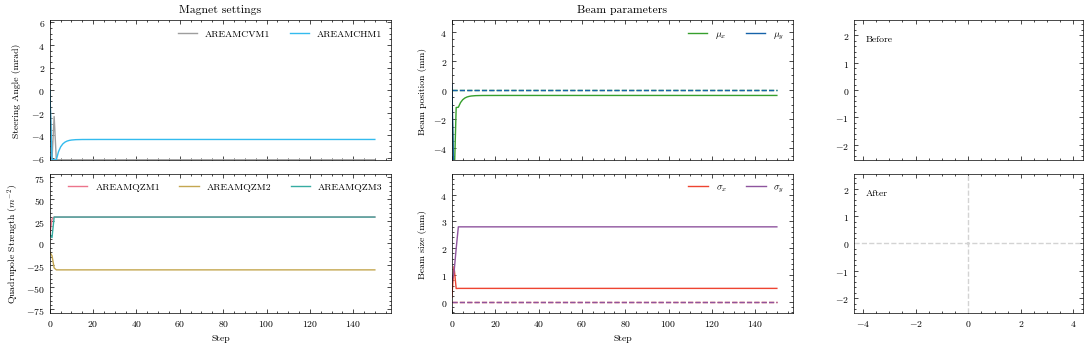

In [7]:
_ = study.episodes[2].plot_summary()